# Tarea : Selección de variables

* Alberto Ramos Sánchez
* Entrega: 30/10/2020 23:00
* Asignatura : Ciencia de Datos
* Máster Universitario de Sistemas Inteligentes y Aplicaciones Numéricas en Ingeniería

## Contenido
* [Tarea : Selección de variables](#Tarea-:-Selección-de-variables)
	* [Introducción](#Introducción)
	* [Carga de datos](#Carga-de-datos)
	* [Selección de búsqueda hacia adelante (SFS)](#Selección-de-búsqueda-hacia-adelante-%28SFS%29)
	* [Definición de medidas de calidad](#Definición-de-medidas-de-calidad)
		* [Medida de mérito](#Medida-de-mérito)
			* [Descripción de la implementación](#Descripción-de-la-implementación)
		* [Medida de información mutua](#Medida-de-información-mutua)
			* [Descripción de la implementación](#Descripción-de-la-implementación)
		* [Definición clase heurística](#Definición-clase-heurística)
	* [Definición de búsqueda sequencial hacia adelante](#Definición-de-búsqueda-sequencial-hacia-adelante)
		* &nbsp;
			* [Descripción de la implementación](#Descripción-de-la-implementación)
	* [Ejecución del método SFS](#Ejecución-del-método-SFS)
		* [Heurística mérito](#Heurística-mérito)
		* [Heurística información mutua](#Heurística-información-mutua)
	* [Resultados](#Resultados)
		* [Correlación entre los atributos del resultado utilizando como heurística el mérito](#Correlación-entre-los-atributos-del-resultado-utilizando-como-heurística-el-mérito)
		* [Información mutua entre los atributos del resultado utilizando como heurística la información mutua de MIFS.](#Información-mutua-entre-los-atributos-del-resultado-utilizando-como-heurística-la-información-mutua-de-MIFS.)
		* [Correlación entre los atributos del resultado utilizando como heurística la información mutua de MIFS.](#Correlación-entre-los-atributos-del-resultado-utilizando-como-heurística-la-información-mutua-de-MIFS.)
	* [Conclusión](#Conclusión)


In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

np.random.seed(1)

from itertools import combinations

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## Introducción

En esta tarea se implementará el método de selección de búsqueda hacia adelante, utilizando, para ello, dos medidas de calidad de subconjuntos de atributos: la propuesta en CFC y la propuesta en MIFS.

## Carga de datos

In [2]:
df_numeric = pd.read_csv('.\\datos\\winequality-white.csv', sep=';')
nmuestras = len(df_numeric)
nvariables = df_numeric.columns.size
print('Num muestras: {}'.format(nmuestras))
print('Num variables: {}'.format(nvariables))

Num muestras: 4898
Num variables: 12


In [3]:
# Convertimos la columna 'quality' a string
df_object = df_numeric.copy()
df_object['quality'] = df_object['quality'].astype(str)

## Selección de búsqueda hacia adelante (SFS)

El funcionamiento de este método de selección consiste en, a partir de un conjunto vacío, ir aumentando el conjunto de atributos uno a uno, seleccionando siempre la mejor solución de acuerdo a una heurística elegida. Este método se considera *greedy*, pues recorre gran parte del conjunto de soluciones.

## Definición de medidas de calidad

Para la implementación en esta tarea utilizaremos dos tipos de heurísticas: la medida de mérito del método CFS, y la medida de información mutua utilizada en el algoritmo MIFS.

### Medida de mérito

La medida de mérito utiliza la correlación entre los atributos y la clase para calcular la calidad de un subconjunto de atributos seleccionados. Esta ecuación se basa en la suposición de que un buen conjunto es aquel que cuyos atributos tienen una alta correlación con la clase y baja entre ellos. Buscando la solución que maximiza la siguiente heurística conseguimos aumentar el valor de la correlación entre atributos y la clase, y disminuirla entre ellos.

El mérito para un subconjunto de atributos seleccionados **S (a ∈ S)**, donde la clase es determinada por una columna **c**, es:

$$
\begin{aligned}
merit_s = \frac{ K*r_{ca} }{ \sqrt{ K + K*(K - 1)*r_{aa} } }
\end{aligned}
$$

donde

* $K$ es el número de atributos seleccionados.
* $r_{aa}$ el promedio de la correlación entre atributos.
* $r_{ca}$ el promedio de la correlación entre los atributos y la clase.


In [4]:
def merito(df: pd.DataFrame, atribs: list, clase: str):
    """
    Retorna valor del mérito para un conjunto candidato
    
    (K*r_ca)/math.sqrt(K + K*(K-1)*r_aa)
    
    df : pd.DataFrame
        dataframe completo
    atribs : list of str
        conjunto de atributos para los que deseamos calcular el mérito
    clase : str
        nombre de la columna clase
    """
    if clase in atribs:
        raise Exception("Error: la columna clase no puede estar en el conjunto seleccionado")
    
    # numero de atributos
    K = len(atribs)
    if K == 0:
        return 0
    
    # (1) calcula promedio correlacion atributo-clase
    corr = df[list(atribs) + [clase]].corr()
    
    # (2) calcula promedio correlacion atributo-clase
    r_ca = corr.loc[:, clase].iloc[:-1]
    r_ca = sum(abs(r_ca))/len(r_ca)
    
    # (3) calcula promedio correlacion atributo-atributo
    r_aa = 0
    
    # recorremos matriz de correlacion buscando las correlaciones atributo-atributo
    for i in range(0, K-1):
        for j in range(i+1, K):
            r_aa += abs(corr.iloc[i ,j])
    n_comb_aa = math.comb(K, 2)
    r_aa /= n_comb_aa if n_comb_aa != 0 else 1
    
    # (4) calcula mérito
    merito = (K*r_ca)/math.sqrt(K + K*(K-1)*r_aa)
    return merito


#### Descripción de la implementación

1. Calculamos la matriz de correlación entre los atributos seleccionados —incluyendo la clase—.
2. Seleccionamos la columna con la correlación entre la clase y los demás atributos (valores en negrilla), y calculamos el promedio.

|                  | fixed acidity | volatile acidity | citric acid | residual sugar | __quality__ |
|------------------|---------------|------------------|-------------|----------------|-------------|
| fixed acidity    | 1.000000      | -0.022697        | 0.289181    | 0.089021       | __-0.113663__  |
| volatile acidity | -0.022697     | 1.000000         | -0.149472   | 0.064286       | __-0.194723__ |
| citric acid      | 0.289181      | -0.149472        | 1.000000    | 0.094212       | __-0.009209__ |
| residual sugar   | 0.089021      | 0.064286         | 0.094212    | 1.000000       | -0.097577 |
| quality          | -0.113663     | -0.194723        | -0.009209   | -0.097577      | 1.000000  |

3. Seleccionamos la correlación de cada atributo con los demás (valores en negrilla) y calculamos el promedio.

|                  | fixed acidity | volatile acidity | citric acid | residual sugar | quality |
|------------------|---------------|------------------|-------------|----------------|-------------|
| fixed acidity    | 1.000000      | __-0.022697__    | __0.289181__| __0.089021__   | -0.113663  |
| volatile acidity | -0.022697     | 1.000000         |__-0.149472__| __0.064286__   | -0.194723 |
| citric acid      | 0.289181      | -0.149472        | 1.000000    | __0.094212__   | -0.009209 |
| residual sugar   | 0.089021      | 0.064286         | 0.094212    | 1.000000       | -0.097577 |
| quality          | -0.113663     | -0.194723        | -0.009209   | -0.097577      | 1.000000  |

4. Aplicamos la ecuación para calcular el mérito.

### Medida de información mutua

La medida de información mutua $I(A, B)$ entre dos atributos mide la reducción de la entropia de una variable aleatoria $A$ al conocer $B$, es decir, cuantifica la incertidumbre de una variable aleatoria A conocida otra variable B. En otras palabras, determina la dependencia de dos variables.

Esta heurística se basa en la misma suposición de antes: un conjunto de atributos es de buena calidad si su dependencia con la clase es mayor que con otros atributos del conjunto. Por ello, se calcula separadamente la información mutua del el nuevo atributo candidato con la clase, y la del atributo con los ya seleccionados. La diferencia entre los dos valores, nos da una heurística con el que seleccionar los atributos cuya dependencia con la clase es alta, sin seleccionar innecesariamente aquellos que tienen una alta dependencia entre si.

$$
\begin{aligned}
X_s = max\{ I(X_s|Y) - \beta*\sum_{X_j \in S}{I(X_s|X_j)}\}
\end{aligned}
$$
donde
* $X_s$ es el atributo candidato.
* $S$ el conjunto de atributos ya seleccionados.
* $Y$ es la clase.


In [5]:
def info_mutua(df: pd.DataFrame, clase: str, new_atrib: str, sel_atribs: list, B : float = 1.):
    """
    Retorna valor de información mutua para un conjunto candidato
    
    I(Y, X_s) - B * sum[X_j ∈ S](I(X_j, X_s))
    
    df : pd.DataFrame 
        dataframe completo
    clase : str
        nombre de la columna clase
    new_atrib : str
        nombre de la columna del nuevo atributo candidato
    sel_atribs : list of str
        nombre de las columnas de los atributos ya seleccionados
    B : float (default = 1.)
        valor B de la ecuación del algoritmo MIFS
    """
    
    # (1) Informacion mutua entre nuevo atributo y la clase
    I_y_xs = mutual_info_classif(df[new_atrib].values.reshape(-1, 1), df[clase].values)[0]
    
    # (2) Sumatoria de informacion mutua entre variable nueva y las seleccionadas
    I_xj_xs = 0
    for xj in sel_atribs:
        I_xj_xs += mutual_info_regression(df[new_atrib].values.reshape(-1, 1), df[xj].values)[0]
    
    return I_y_xs - B * I_xj_xs


#### Descripción de la implementación

1. Calculamos la información mutua entre el atributo candidato y la clase.
2. Calculamos la sumatoria de la información mutua entre el atributo candidato y los atributos seleccionados en $S$.
3. Restamos aplicando un factor $\beta$, con el que se modula la importancia de la dependencia entre el atributo candidato y los seleccionados.

### Definición clase heurística

Definimos una clase heurística con la que simplificar la aplicación de la heurística en el método

In [6]:
class Heuristic:
    
    def __init__(self):
        pass
    
    def __call__(self, df: pd.DataFrame, S: set, Xs: str, clase: str):
        """
        df : dataframe
        S : set de columnas ya seleccionadas
        Xs : columna candidata
        clase : columna clase
        """
        raise NotImplementedError("Heuristic is a base class")

In [7]:
class Merit(Heuristic):
    def __init__(self):
        super().__init__()
    
    def __call__(self, df: pd.DataFrame, S: set, Xs: str, clase: str):
        return merito(df, list(S) + [Xs], clase)

#merit_h = Merit()
#merit_h(df_numeric, set(df_numeric.columns[0:2]), df_numeric.columns[3], 'quality')

In [8]:
class InfoMutua(Heuristic):
    def __init__(self, beta : float = 1.):
        super().__init__()
        self.__beta = beta
    
    def __call__(self, df: pd.DataFrame, S: set, Xs: str, clase: str):
        return info_mutua(df, 'quality', Xs, list(S), self.__beta)

#info_mutua_h = InfoMutua(1)
#info_mutua_h(df_numeric, set(df_numeric.columns[0:2]), df_numeric.columns[3], 'quality')

## Definición de búsqueda sequencial hacia adelante

En esta búsqueda, como se ha explicado antes, se parte de un conjunto vacío de atributos seleccionados. Uno a uno, se van seleccionando atributos hasta alcanzar el número de atributos requeridos. Se seleccionan primero los atributos que maximizan el valor de la heurística escogida para el conjunto de atributos seleccionados. Para esta implementación se tienen dos heurísticas: mérito e información mutua.

In [9]:
def combinations_including(s, r, contain=set()):
    """
    Retorna una lista de combinaciones del conjunto S, de tamaño r, que contiene los elementos de contain
    
    s : conjunto para generar combinaciones
    r : tamaño de las combinaciones (len(s) >= r)
    contain : conjunto de elementos de s que deben estar en las combinaciones generadas
    """
    assert len(s) >= r
    if type(contain) is not set:
        contain = set(contain)
    
    sub_r = r - len(contain)
    extend_elems = s.difference(contain)
    subset_comb = combinations(extend_elems, sub_r)
    
    return [tuple(contain) + e for e in subset_comb]


In [10]:
def sfs(df: pd.DataFrame, clase : str, r: int, method: Heuristic):
    """
    Retorna dataframe reducido a r columnas
    
    df : pd.DataFrame 
        dataframe completo
    clase: nombre de la clase
    r : número de atributos del resultado
    method : instancia de la Heurística a aplicar
    """
    
    cols = set(df.columns.drop(clase))
    S = set() # Conjunto de elementos seleccionados
    
    # (1) Seleccionamos uno a uno los atributos hasta llegar a r atributos
    for dim in range(1, r+1):
        
        # (2) Generamos las combinaciones posibles
        options = combinations_including(cols, dim, S)
        
        # (3) Buscamos el conjunto que maximiza la heurística
        max_Xs = list(set(options[0]).difference(S))[0]
        max_heur = method(df, S, max_Xs, 'quality')
        
        #print("Options: dim={}".format(dim))
        for opt in options:
            Xs = list(set(opt).difference(S))[0] # Atributo candidato (eliminamos los ya seleccionados en S)
            
            heur = method(df, S, Xs, 'quality')
            
            #print("\t {} {}".format(Xs, heur))
            if heur > max_heur:
                max_Xs = Xs
                max_heur = heur
        #print("\tSelect: {}".format(max_Xs))
        
        # (4) Añadimos el seleccionado
        if max_Xs is not None:
            S.add(max_Xs)
    
    # (5) Selecciona columnas del conjunto S más la columna clase
    return df[sorted(list(S)) + [clase]]


#### Descripción de la implementación

1. En esta implementación se van añadiendo uno a uno los atributos con mayor heurística al conjunto de atributos seleccionados $S$.
2. En cada iteración generamos las posibles combinaciones sin repetición que incluyen los atributos ya seleccionados en $S$ más un atributo más.
3. La heurística a utilizar se pasa como parámetro en *method*, que es una instancia de la clase *Heuristic* antes explicada. En el paso 3 se busca entre todas las combinaciones generadas aquella que tenga un valor mayor de heurística.
4. Una vez encontrado el atributo candidato que maximiza la heurística, se añade al conjunto $S$.
5. Finalmente se selecciona en el dataset las columnas correspondientes al conjunto de atributos $S$, y la columna clase.

## Ejecución del método SFS

### Heurística mérito

#### 2 columnas

In [11]:
merit_result_2 = sfs(df_numeric, 'quality', 2, Merit())
print(merit_result_2.columns.values)

['alcohol' 'volatile acidity' 'quality']


#### 4 columnas

In [12]:
merit_result_4 = sfs(df_numeric, 'quality', 4, Merit())
print(merit_result_4.columns.values)

['alcohol' 'chlorides' 'density' 'volatile acidity' 'quality']


#### 8 columnas

In [13]:
merit_result_8 = sfs(df_numeric, 'quality', 8, Merit())
print(merit_result_8.columns.values)

['alcohol' 'chlorides' 'density' 'fixed acidity' 'pH' 'sulphates'
 'total sulfur dioxide' 'volatile acidity' 'quality']


### Heurística información mutua

### *$\beta$ = 1.0*

#### 2 columnas

In [14]:
mutua_result_2_b1 = sfs(df_object, 'quality', 2, InfoMutua())
print(mutua_result_2_b1.columns.values)

['density' 'volatile acidity' 'quality']


#### 4 columnas

In [15]:
mutua_result_4_b1 = sfs(df_object, 'quality', 4, InfoMutua())
print(mutua_result_4_b1.columns.values)

['density' 'fixed acidity' 'sulphates' 'volatile acidity' 'quality']


#### 8 columnas

In [16]:
mutua_result_8_b1 = sfs(df_object, 'quality', 8, InfoMutua())
print(mutua_result_8_b1.columns.values)

['chlorides' 'citric acid' 'density' 'fixed acidity' 'free sulfur dioxide'
 'pH' 'sulphates' 'volatile acidity' 'quality']


### *$\beta$ = 0.50*

#### 2 columnas

In [17]:
mutua_result_2_b05 = sfs(df_object, 'quality', 2, InfoMutua(0.5))
print(mutua_result_2_b05.columns.values)

['density' 'volatile acidity' 'quality']


#### 4 columnas

In [18]:
mutua_result_4_b05 = sfs(df_object, 'quality', 4, InfoMutua(0.5))
print(mutua_result_4_b05.columns.values)

['density' 'fixed acidity' 'sulphates' 'volatile acidity' 'quality']


#### 8 columnas

In [19]:
mutua_result_8_b05 = sfs(df_object, 'quality', 8, InfoMutua(0.5))
print(mutua_result_8_b05.columns.values)

['chlorides' 'citric acid' 'density' 'fixed acidity' 'free sulfur dioxide'
 'pH' 'sulphates' 'volatile acidity' 'quality']


### *$\beta$ = 0.25*

#### 2 columnas

In [20]:
mutua_result_2_b025 = sfs(df_object, 'quality', 2, InfoMutua(0.25))
print(mutua_result_2_b025.columns.values)

['density' 'volatile acidity' 'quality']


#### 4 columnas

In [21]:
mutua_result_4_b025 = sfs(df_object, 'quality', 4, InfoMutua(0.25))
print(mutua_result_4_b025.columns.values)

['density' 'fixed acidity' 'free sulfur dioxide' 'volatile acidity'
 'quality']


#### 8 columnas

In [22]:
mutua_result_8_b025 = sfs(df_object, 'quality', 8, InfoMutua(0.25))
print(mutua_result_8_b025.columns.values)

['chlorides' 'citric acid' 'density' 'fixed acidity' 'free sulfur dioxide'
 'pH' 'sulphates' 'volatile acidity' 'quality']


## Resultados

### Correlación entre los atributos del resultado utilizando como heurística el mérito

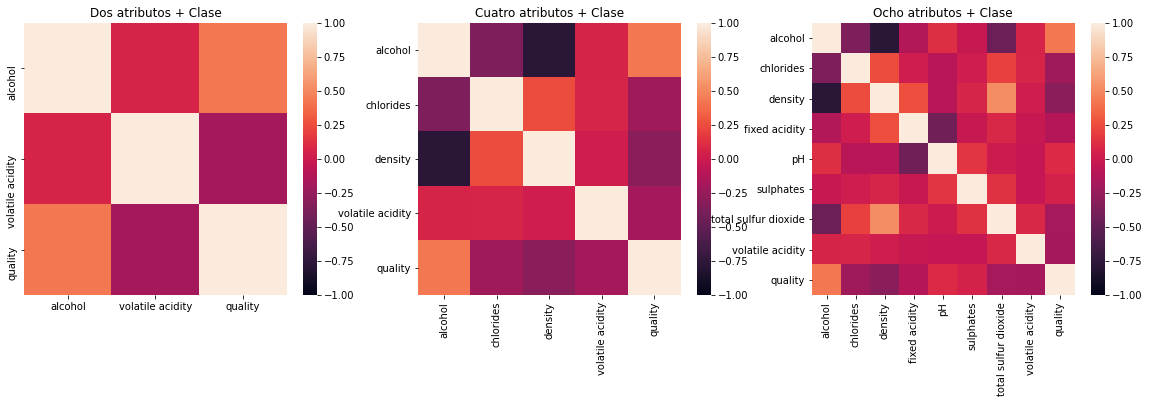

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.despine(left=True)

sns.heatmap(merit_result_2.corr(), 
            ax=ax[0],
            xticklabels=merit_result_2.columns,
            yticklabels=merit_result_2.columns,
            vmin=-1, vmax=1)

sns.heatmap(merit_result_4.corr(), 
            ax=ax[1],
            xticklabels=merit_result_4.columns,
            yticklabels=merit_result_4.columns,
            vmin=-1, vmax=1)

sns.heatmap(merit_result_8.corr(), 
            ax=ax[2],
            xticklabels=merit_result_8.columns,
            yticklabels=merit_result_8.columns,
            vmin=-1, vmax=1)

ax[0].title.set_text('Dos atributos + Clase')
ax[1].title.set_text('Cuatro atributos + Clase')
ax[2].title.set_text('Ocho atributos + Clase')


En la primera matriz de correlación vemos como se han seleccionado los atributos que tienen alta correlación con la clase y baja entre si. A medida que aumentamos el número de atributos, se hace necesario empezar a seleccionar atributos con alta correlación entre si, como la densidad y el alcohol. Cuando el número de atributos empieza a acercarse al total del *dataset* original, la diferencia entre la correlación con la clase y entre atributos se hace menos notable.

### Información mutua entre los atributos del resultado utilizando como heurística la información mutua de MIFS.

Dado que este método utiliza la información mutua, vamos a calcular la información mutua de cada conjunto resultado entre sus atributos, para así comparar los resultados. Nos vamos a ayudar del método *informacion_mutua_conjunto*.

In [24]:
def informacion_mutua_conjunto(df, atribs):
    im = [mutual_info_regression(df.loc[:, atribs], df.iloc[:, i]) for i in range(len(atribs))]
    
    # ignoramos la diagonal de la matriz
    for i, _ in enumerate(im): im[i][i] = 0
    
    return pd.DataFrame(im, index=atribs, columns=atribs)

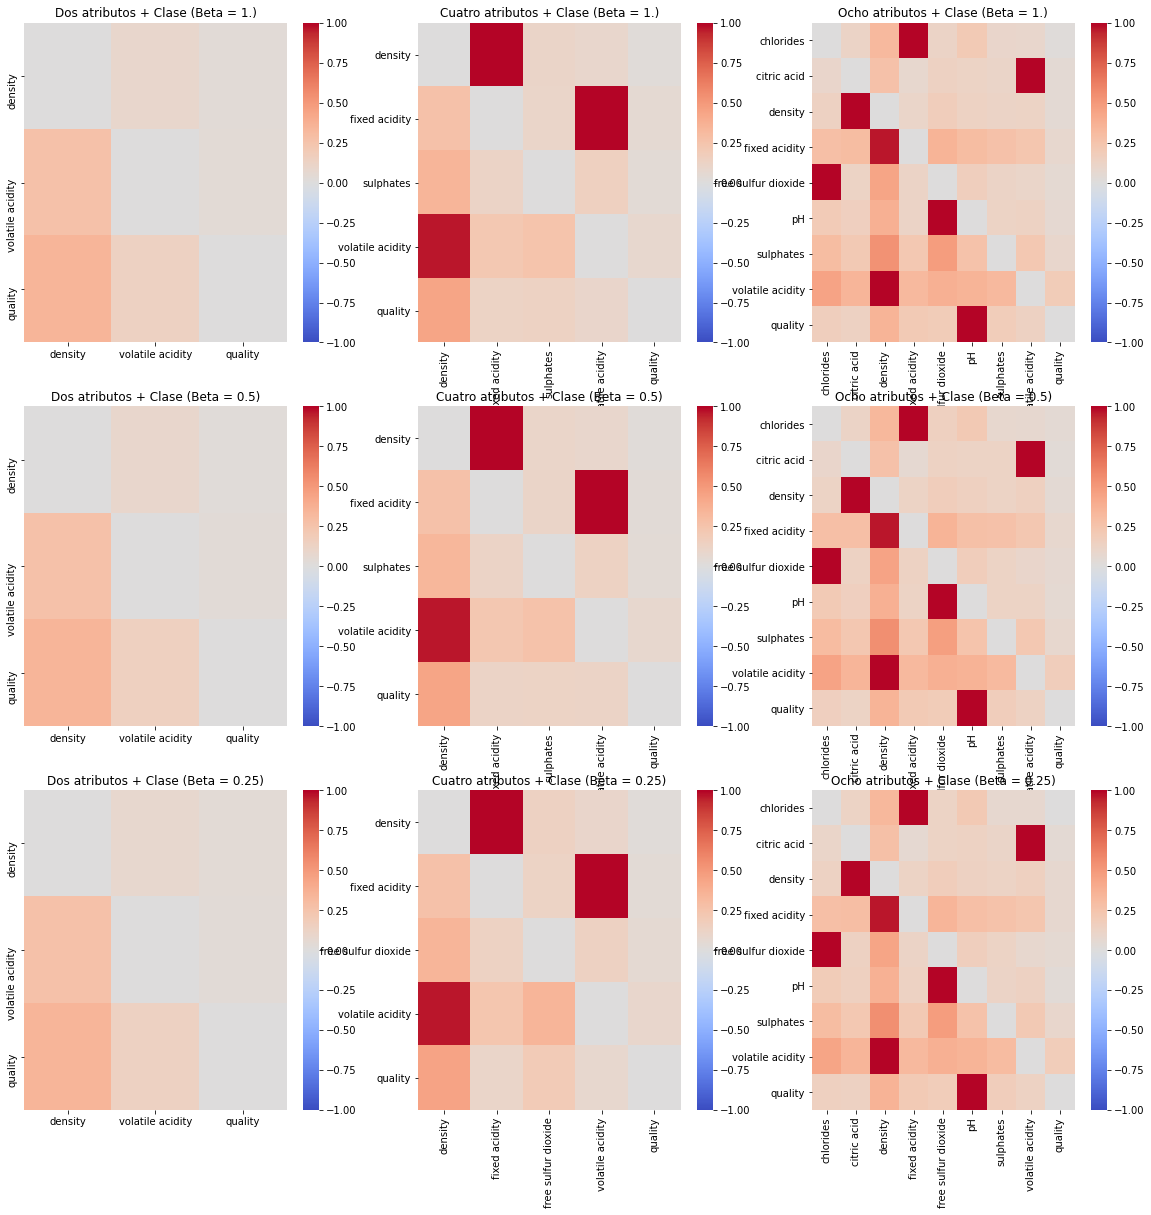

In [25]:

f, ax = plt.subplots(3, 3, figsize=(20, 20))

sns.despine(left=True)

# beta 1

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_2_b1.columns), 
            ax=ax[0, 0],
            xticklabels=mutua_result_2_b1.columns,
            yticklabels=mutua_result_2_b1.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_4_b1.columns), 
            ax=ax[0, 1],
            xticklabels=mutua_result_4_b1.columns,
            yticklabels=mutua_result_4_b1.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_8_b1.columns), 
            ax=ax[0, 2],
            xticklabels=mutua_result_8_b1.columns,
            yticklabels=mutua_result_8_b1.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

# beta 0.5

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_2_b05.columns), 
            ax=ax[1, 0],
            xticklabels=mutua_result_2_b05.columns,
            yticklabels=mutua_result_2_b05.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_4_b05.columns), 
            ax=ax[1, 1],
            xticklabels=mutua_result_4_b05.columns,
            yticklabels=mutua_result_4_b05.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_8_b05.columns), 
            ax=ax[1, 2],
            xticklabels=mutua_result_8_b05.columns,
            yticklabels=mutua_result_8_b05.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

# beta 0.25

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_2_b025.columns), 
            ax=ax[2, 0],
            xticklabels=mutua_result_2_b025.columns,
            yticklabels=mutua_result_2_b025.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_4_b025.columns), 
            ax=ax[2, 1],
            xticklabels=mutua_result_4_b025.columns,
            yticklabels=mutua_result_4_b025.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(informacion_mutua_conjunto(df_numeric, mutua_result_8_b025.columns), 
            ax=ax[2, 2],
            xticklabels=mutua_result_8_b025.columns,
            yticklabels=mutua_result_8_b025.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

ax[0, 0].title.set_text('Dos atributos + Clase (Beta = 1.)')
ax[0, 1].title.set_text('Cuatro atributos + Clase (Beta = 1.)')
ax[0, 2].title.set_text('Ocho atributos + Clase (Beta = 1.)')

ax[1, 0].title.set_text('Dos atributos + Clase (Beta = 0.5)')
ax[1, 1].title.set_text('Cuatro atributos + Clase (Beta = 0.5)')
ax[1, 2].title.set_text('Ocho atributos + Clase (Beta = 0.5)')

ax[2, 0].title.set_text('Dos atributos + Clase (Beta = 0.25)')
ax[2, 1].title.set_text('Cuatro atributos + Clase (Beta = 0.25)')
ax[2, 2].title.set_text('Ocho atributos + Clase (Beta = 0.25)')

Podemos observar que la información mutua entre los atributos seleccionados aumenta a medida que aumentamos el número de atributos y disminuimos el valor de $\beta$.

### Correlación entre los atributos del resultado utilizando como heurística la información mutua de MIFS.

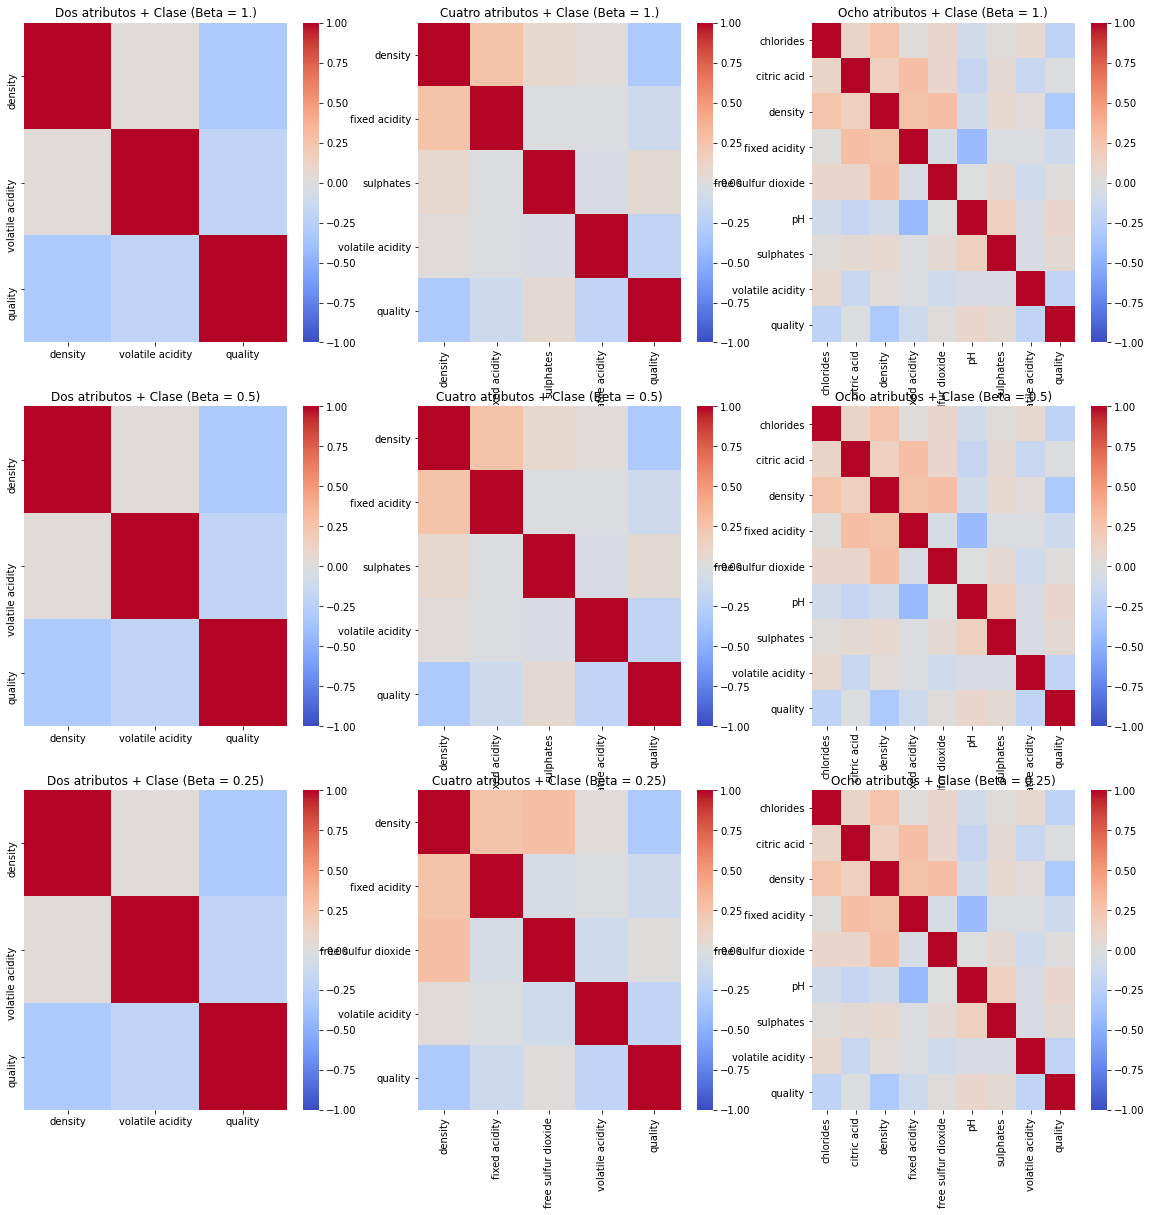

In [26]:

f, ax = plt.subplots(3, 3, figsize=(20, 20))

sns.despine(left=True)

# beta 1

sns.heatmap(df_numeric.loc[:, mutua_result_2_b1.columns].corr(), 
            ax=ax[0, 0],
            xticklabels=mutua_result_2_b1.columns,
            yticklabels=mutua_result_2_b1.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(df_numeric.loc[:, mutua_result_4_b1.columns].corr(), 
            ax=ax[0, 1],
            xticklabels=mutua_result_4_b1.columns,
            yticklabels=mutua_result_4_b1.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(df_numeric.loc[:, mutua_result_8_b1.columns].corr(), 
            ax=ax[0, 2],
            xticklabels=mutua_result_8_b1.columns,
            yticklabels=mutua_result_8_b1.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

# beta 0.5

sns.heatmap(df_numeric.loc[:, mutua_result_2_b05.columns].corr(), 
            ax=ax[1, 0],
            xticklabels=mutua_result_2_b05.columns,
            yticklabels=mutua_result_2_b05.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(df_numeric.loc[:, mutua_result_4_b05.columns].corr(), 
            ax=ax[1, 1],
            xticklabels=mutua_result_4_b05.columns,
            yticklabels=mutua_result_4_b05.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(df_numeric.loc[:, mutua_result_8_b05.columns].corr(), 
            ax=ax[1, 2],
            xticklabels=mutua_result_8_b05.columns,
            yticklabels=mutua_result_8_b05.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

# beta 0.25

sns.heatmap(df_numeric.loc[:, mutua_result_2_b025.columns].corr(), 
            ax=ax[2, 0],
            xticklabels=mutua_result_2_b025.columns,
            yticklabels=mutua_result_2_b025.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(df_numeric.loc[:, mutua_result_4_b025.columns].corr(), 
            ax=ax[2, 1],
            xticklabels=mutua_result_4_b025.columns,
            yticklabels=mutua_result_4_b025.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

sns.heatmap(df_numeric.loc[:, mutua_result_8_b025.columns].corr(), 
            ax=ax[2, 2],
            xticklabels=mutua_result_8_b025.columns,
            yticklabels=mutua_result_8_b025.columns,
            vmin=-1, vmax=1,
            cmap= 'coolwarm')

ax[0, 0].title.set_text('Dos atributos + Clase (Beta = 1.)')
ax[0, 1].title.set_text('Cuatro atributos + Clase (Beta = 1.)')
ax[0, 2].title.set_text('Ocho atributos + Clase (Beta = 1.)')

ax[1, 0].title.set_text('Dos atributos + Clase (Beta = 0.5)')
ax[1, 1].title.set_text('Cuatro atributos + Clase (Beta = 0.5)')
ax[1, 2].title.set_text('Ocho atributos + Clase (Beta = 0.5)')

ax[2, 0].title.set_text('Dos atributos + Clase (Beta = 0.25)')
ax[2, 1].title.set_text('Cuatro atributos + Clase (Beta = 0.25)')
ax[2, 2].title.set_text('Ocho atributos + Clase (Beta = 0.25)')



Se observa en las dos primeras columnas (2 y 4 atributos) que las columnas seleccionadas tienen una correlación mayor con la clase que entre ellas —es prácticamente cero para la mayoría de pares de atributos—. A medida que se aumenta el número de atributos, esta diferencia es menos evidente. Asimismo, al disminuir el valor de $\beta$, la correlación entre atributos aumenta.

## Conclusión

Tras estudiar los resultados obtenidos, podemos afirmar que el método de información mutua MIFS es capaz de seleccionar de forma más eficaz las columnas con mayor dependencia con la clase, rechazando aquellos pares de atributos que son altamente dependientes entre sí.